In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

## Material parameters and other general definitions

In [2]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha_YIG = 1.75e-4    # Gilbert damping (-)

Ms_YIG = 140.7e3           # Saturation magnetisation (A/m). 

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

l_ex = (2*A_YIG/(mm.consts.mu0*Ms_YIG**2)) # Exchange length (m)


## Sample and mesh cell creation

In [3]:
# Geometry [m]
l = 60e-6
w = 500e-9
t = 50e-9


# self absorbing boundary condition
band = 1e-6

sourceWidth=600e-9 #cercare bene la misura sul righello
sourcePos=-l/4 #almeno iniettiamo le waves nel bulk, possiamo modificare


# Mesh cell [m]
cx = 10e-9   #50e-9
cy = w  #50e-9
cz = t

cell = (cx, cy, cz)

# Zeeman field
Hx = 550 * Oe # 550 Oe = 55mT as in the paper
Hy = 0
Hz = 0
H_DC = (Hx, Hy, Hz)

# Amplitude of RF exiting field
H_RF_val = 10 * Oe

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization




## Energy and boundary conditions definition

In [4]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driverc


## Time simulation parameter definition

In [5]:
T = 100e-9 #100e-9
f_MAX = 4e9 
f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling

## System definition

In [6]:
sysName=f"P1_{int(T*1e9)}ns_{int(f_MAX*1e-9)}GHz"
print(sysName)

P1_100ns_4GHz


In [7]:
system = mm.System(name=sysName)
region = df.Region(p1=(-l/2, -w/2, 0), p2=(l/2, w/2, t))
mesh = df.Mesh(region=region, cell=cell)

def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_YIG)

    else:
        return (alpha_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)

## System initialization

In [8]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

## Check system current state

In [9]:
def plotM(system,axis):
    
    if axis=="x":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_x$')
        """
            system.m accesses the megnetization
            m.x accesses the x component
            x.sel("z") means "sliced at a fixed value of z", by defaut the middle of the system
            from mpl.scalar on it's just about putting the red/blue color code on the right
            """
        system.m.x.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
        """
            this basically just shows the vaues of the vector field m, as colored dots/arrows. 
            Uses the matplotlib.quiver method
            for low fields you only see yellow dots since the equilibrium magnetization is parallel to z
            """
    elif axis=="y":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_y$')
        system.m.y.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
    elif axis=="z":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_z$')
        system.m.z.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

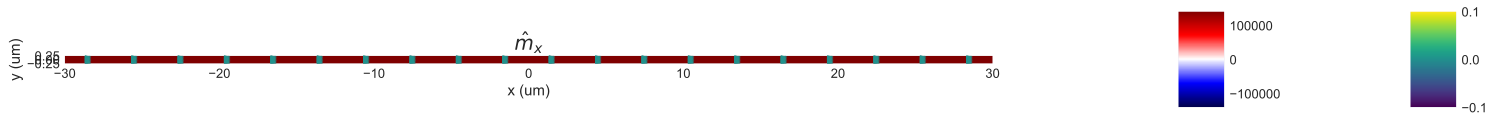

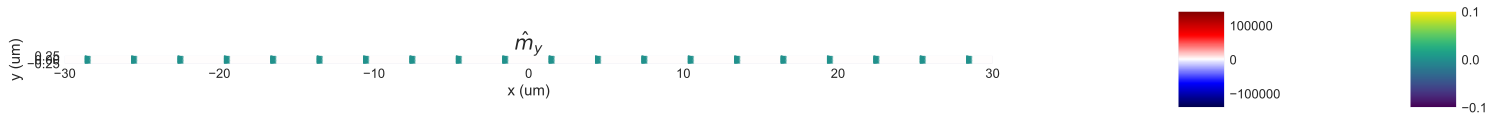

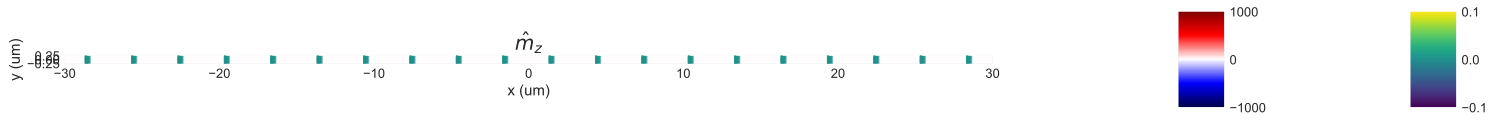

In [10]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")
      

## Drive to equilibrium state

In [11]:
# get system to equilibrium
system.energy = dem + ex + zem
mn.drive(system)

damping = mm.Damping(alpha=alpha)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/02/07 12:51]... (5.9 s)


## Check the starting position where the spin waves will be injected

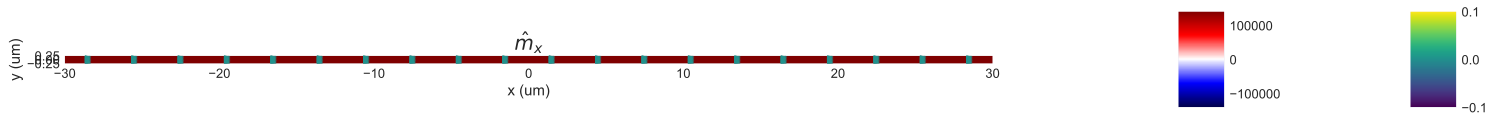

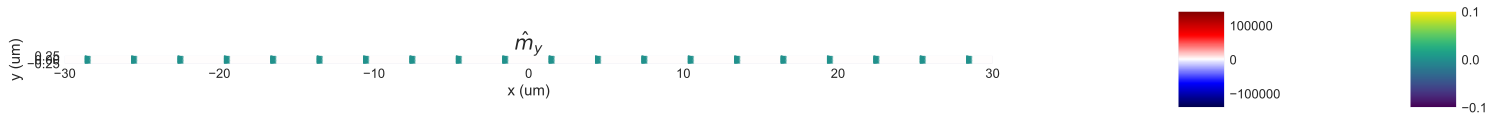

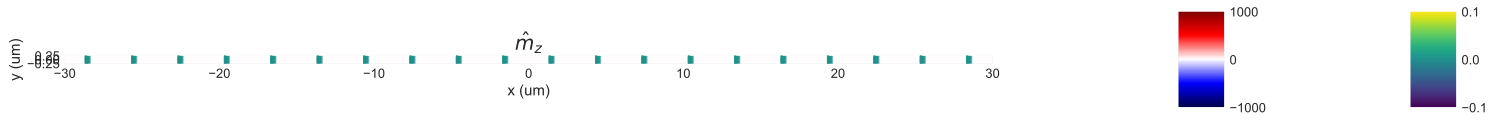

In [12]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")

## RF injection

In [13]:
def Hspace_RF(point):
    x, y, z = point
    if (sourcePos-sourceWidth/2< x < sourcePos+sourceWidth/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, H_RF_val)
    else:
        return (0,0,0)



H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func='sin', f=f_MAX, t0=T/sampling, name='RF')
try:
    system.energy += zemRF
finally:
    td.drive(system, t=T, n=sampling, n_threads=19, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/850 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/02/07 12:52] took 163.0 s


In [14]:
data = md.Data(sysName)[-1]

array = data.to_xarray()


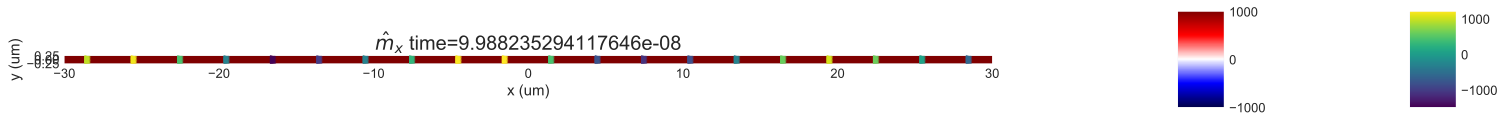

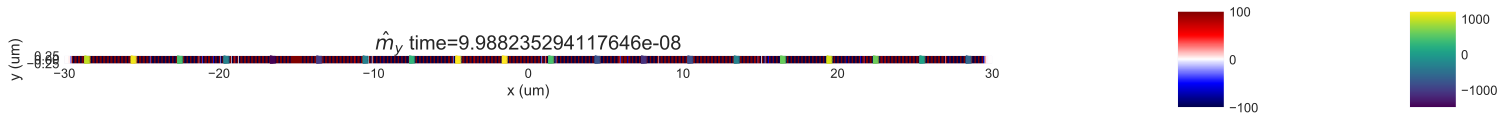

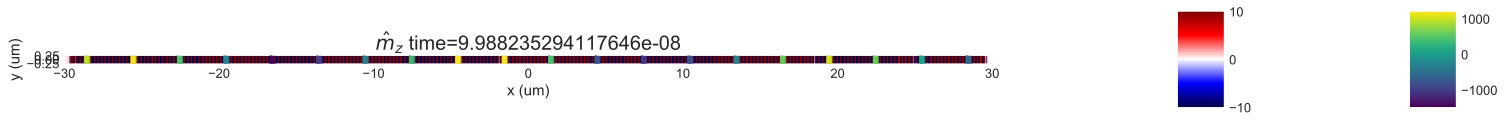

In [15]:
fig,ax =plt.subplots(figsize=(25,10))

plt.title('$\hat m_x$ time='+str((sampling-1)*t_0))
data[sampling-1].x.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_y$ time='+str((sampling-1)*t_0))
data[sampling-1].y.sel('z').mpl.scalar(ax=ax,vmin=-100,vmax=100,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

fig,ax =plt.subplots(figsize=(25,10))
plt.title('$\hat m_z$ time='+str((sampling-1)*t_0))
data[sampling-1].z.sel('z').mpl.scalar(ax=ax,vmin=-10,vmax=10,cmap='seismic')
data[sampling-1].sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

plt.show()

prende l'ultimo drive, su tutti i sample (:), su tutti i valori di x dove l'assorbimento è basso (lontano dai bordi), su un fissato t e un fissato z. L'ultima cifra nella [] indica la componente x, y o z di m dovrebbero essere numsample*numMesh lungo x

In [16]:
data_np = np.array(array)

mx = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 0]
my = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 1]
mz = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 2]

In [17]:
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

In [18]:
import matplotlib.colors as colors
import os
directory="images"
parentDir=f"{sysName}"
path=os.path.join(parentDir,directory)
if not os.path.isdir(path):
    os.mkdir(path)

# Show the intensity plot of the 2D FFT
def plotDispersion(m_fft,xbounds,ybounds,dim):
    #mx
    plt.figure(figsize=(10, 10))

    extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
    plt.imshow(np.log(np.abs(m_fft)**2), extent=extent,
           aspect='auto', origin='lower', norm=colors.CenteredNorm(vcenter=22), cmap="inferno")
    plt.ylabel("$f$ (Hz)")
    plt.xlabel("$kx$ (1/m)")
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    if dim=="x":
        plt.title('F(mx)')
        plt.savefig(f'{sysName}/images/F(mx).png', bbox_inches='tight')
    elif dim=="y":
        plt.title('F(my)')
        plt.savefig(f'{sysName}/images/F(my).png', bbox_inches='tight')
    if dim=="z":
        plt.title('F(mz)')
        plt.savefig(f'{sysName}/images/F(mz).png', bbox_inches='tight')

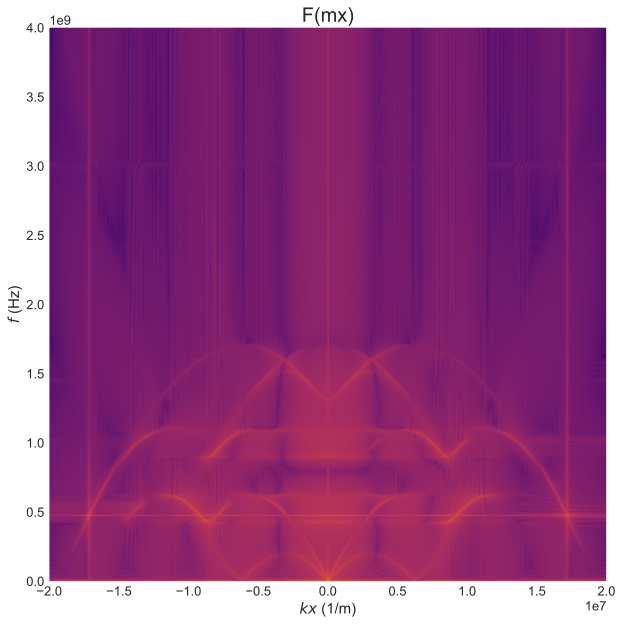

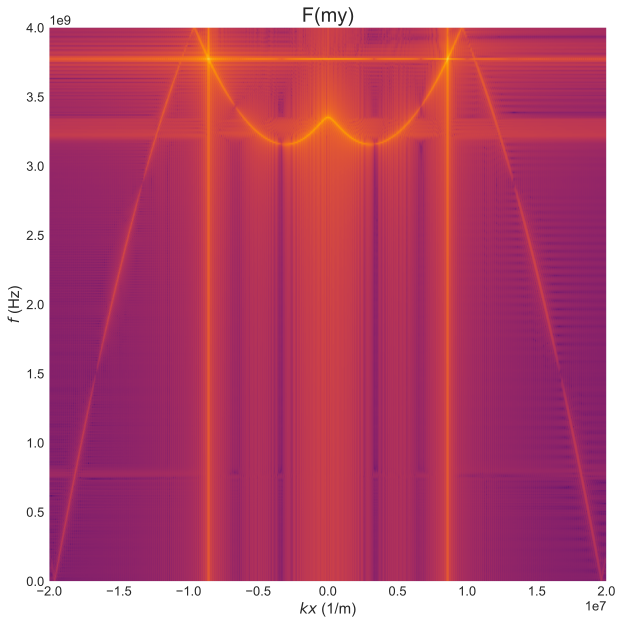

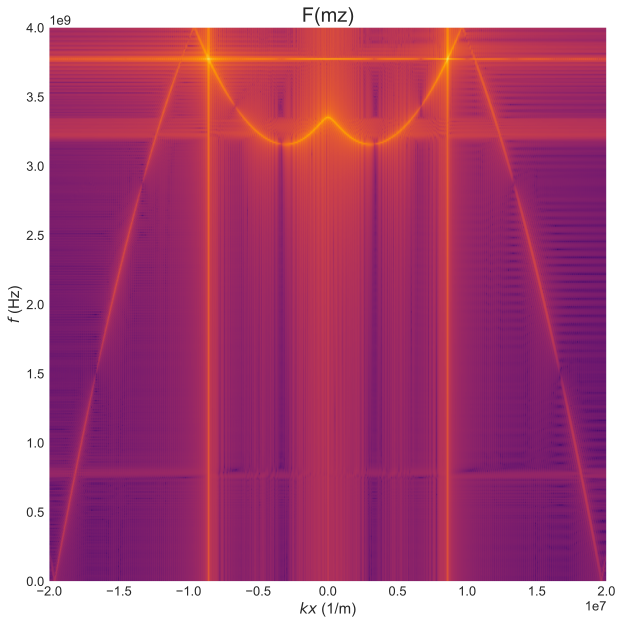

In [19]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x')
plotDispersion(m_fft_y,xbounds,ybounds,'y')

plotDispersion(m_fft_z,xbounds,ybounds,'z')

### Save simulation parameters in params.txt file

In [20]:
#import os
#cwd = os.getcwd()

with open(f"{sysName}/params.txt",'w') as f:
    if cy==w and cz==t:
        f.write(f"cell=({cx},w,t)\n")
    elif cy==w:
        f.write(f"cell=({cx},w,{cz})\n")
    elif cz==t:
        f.write(f"cell=({cx},{cy},t)\n")
    else:
        f.write(f"cell=({cx},{cy},{cz})")
    f.write("\n")
    f.write("Bias field:\n")
    f.write(f"Hx={Hx/Oe}Oe\n")
    f.write(f"Hy={Hy/Oe}Oe\n")
    f.write(f"Hz={Hz/Oe}Oe\n")
    f.write("\n")
    f.write("Exitation field:\n")
    f.write(f"Amplitude={H_RF_val/Oe}Oe\n")
    f.write(f"f_MAX={f_MAX}\n")

In [21]:

# from celluloid import Camera
# fig, ax = plt.subplots(figsize=(20, 5))
# camera = Camera(fig)

# for i in range(sampling): 
    
#     data[-1][i].y.sel('z').mpl.scalar(ax=ax,cmap='seismic',interpolation='bilinear',
#     colorbar=False,vmin=-10,vmax=10,multiplier=1e-9,
#     )
#     camera.snap()
    
    
# animation=camera.animate()
# filename='SW.gif'
# animation.save(filename,writer='Pillow',fps=5)

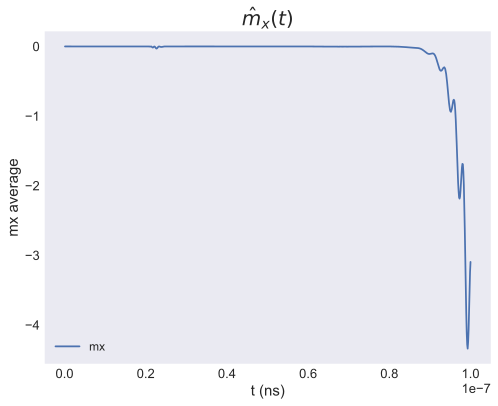

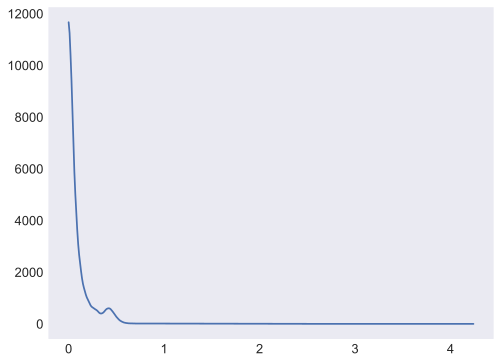

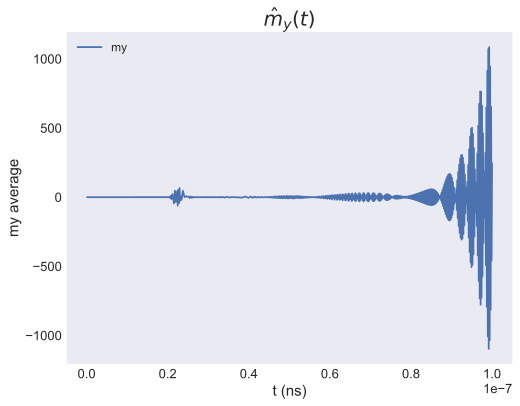

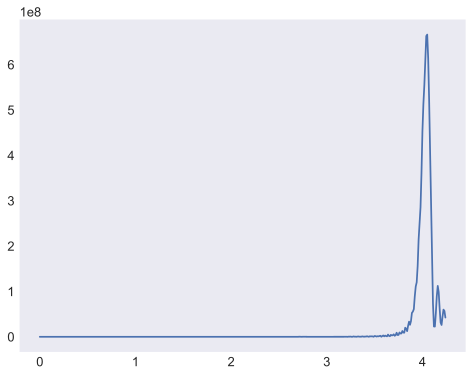

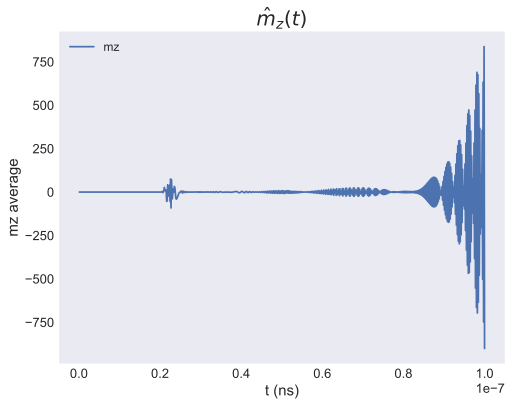

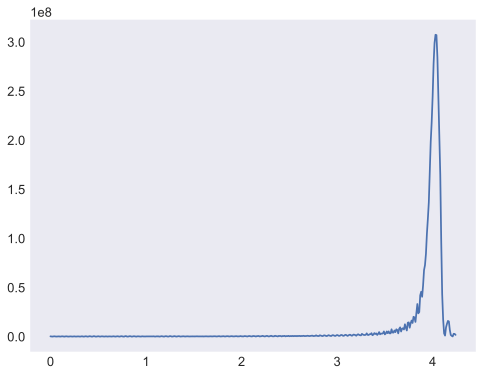

In [22]:
time=system.table.data["t"].values #.values returns a numpy array-> FFT



data=md.Data(sysName) #this contains all the drives up to now. [-1] means the last drive. Check the folder "Py_disk_FMR"
array=data[-1].to_xarray()
#print(len(list(data)))
mz1=[]
mx1=[]
my1=[]

for i in range(sampling):
    value_z=array[i, int((l-2*band)/cx), int(w/2/cy), 0][2]
    value_x=array[i, int((l-2*band)/cx), int(w/2/cy), 0][0]
    value_y=array[i, int((l-2*band)/cx), int(w/2/cy), 0][1]

    """the above means:
    -we take the value of the magnetization at the i-th sampling operation
    -at position mesh[int(r/cx),int(r/cy),0]
    -along the z axis (x=0, y=1, z=2) 
    note that mz is the global magnetization average, so we have smaller oscillations, while mz1 is the LOCAL magnetization
    """
    mz1.append(value_z)
    mx1.append(value_x)
    my1.append(value_y)


#mx(t)
dmx=[i-mx1[0] for i in mx1]
plt.figure()
plt.title('$\hat m_x(t)$')
plt.plot(time,dmx)
plt.xlabel('t (ns)')
plt.ylabel('mx average')
plt.legend(['mx'])
plt.show()
amp=np.abs(np.fft.fft(dmx))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])


#my(t)
dmy=[i-my1[0] for i in my1]
plt.figure()
plt.title('$\hat m_y(t)$')
plt.plot(time,dmy)
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.legend(['my'])
plt.show()
amp=np.abs(np.fft.fft(dmy))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

#mz
dmz=[i-mz1[0] for i in mz1]
plt.figure()
plt.title('$\hat m_z(t)$')
plt.plot(time,dmz)
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(dmz))**2
f_axis=np.fft.fftfreq(sampling,d=T/sampling)
plt.plot(f_axis[0:round(sampling/2)]/1e9, amp[0:round(sampling/2)])

In [23]:
numCells=int((l-2*band)/cx)
space= np.linspace(-l/2+band,l/2-band,numCells)
print(np.shape(space))
data=md.Data(sysName) #this contains all the drives up to now. [-1] means the last drive. Check the folder "Py_disk_FMR"
array=data[-1].to_xarray()
#print(len(list(data)))


value_z=array[sampling-1, round((band)/cx):round((l-band)/cx), int(w/2/cy), 0,2]
value_x=array[sampling-1, round((band)/cx):round((l-band)/cx), int(w/2/cy), 0,0]
value_y=array[sampling-1, round((band)/cx):round((l-band)/cx), int(w/2/cy), 0,1]
print(np.shape(value_x))
dmx=[i-mx1[0] for i in value_x]
dmy=[i-my1[0] for i in value_y]
dmz=[i-mz1[0] for i in value_z]



(5800,)
(5800,)


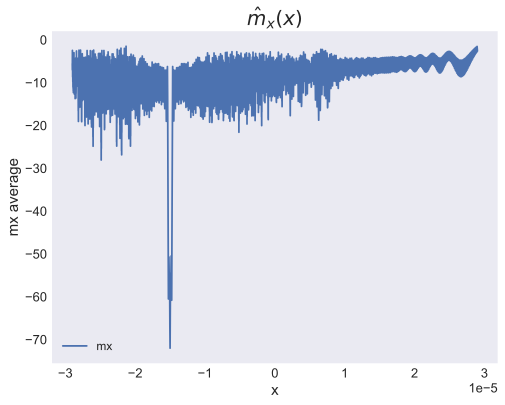

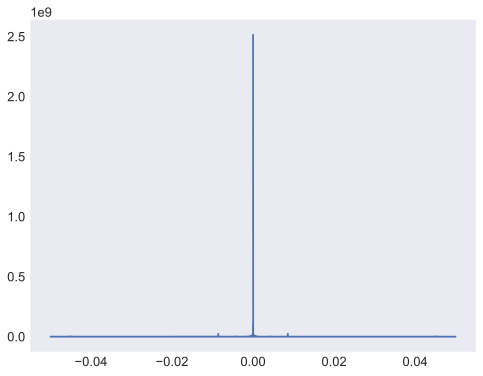

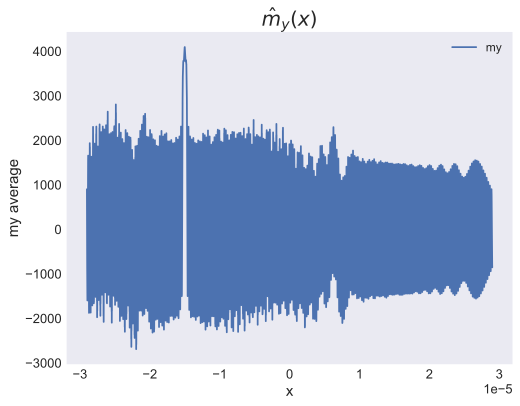

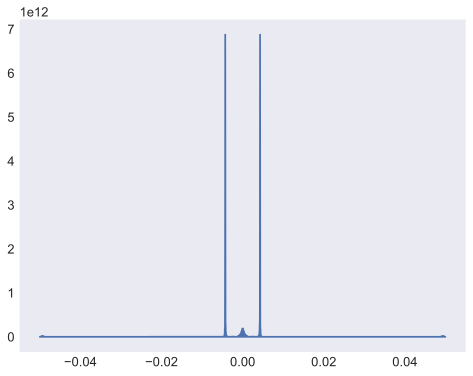

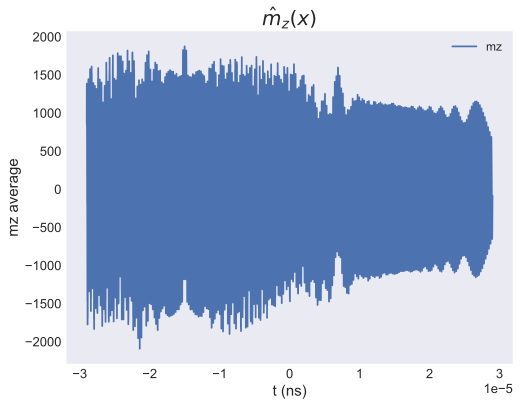

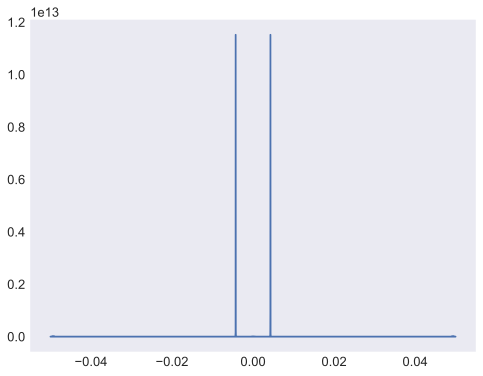

In [24]:

#mx(x)
plt.figure()
plt.title('$\hat m_x(x)$')
plt.plot(space,dmx)
plt.xlabel('x')
plt.ylabel('mx average')
plt.legend(['mx'])
plt.show()
amp=np.abs(np.fft.fft(dmx))**2
f_axis=np.fft.fftfreq(numCells,d=cx)
plt.plot(f_axis/1e9, amp)


#my(x)
plt.figure()
plt.title('$\hat m_y(x)$')
plt.plot(space,dmy)
plt.xlabel('x')
plt.ylabel('my average')
plt.legend(['my'])
plt.show()
amp=np.abs(np.fft.fft(dmy))**2
f_axis=np.fft.fftfreq(numCells,d=cx)
plt.plot(f_axis/1e9, amp)

#mz(x)
plt.figure()
plt.title('$\hat m_z(x)$')
plt.plot(space,dmz)
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(dmz))**2
f_axis=np.fft.fftfreq(numCells,d=cx)
plt.plot(f_axis/1e9, amp)



In [25]:
tan = [a/b for a,b in zip(dmx,dmy)]

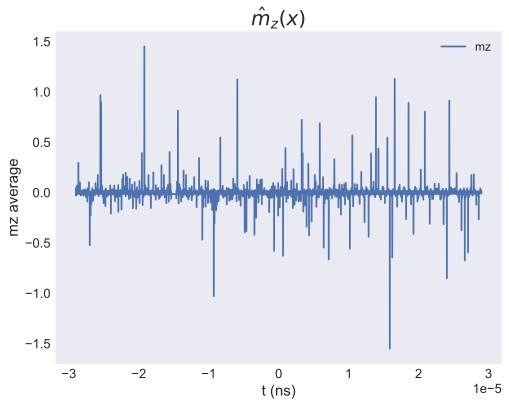

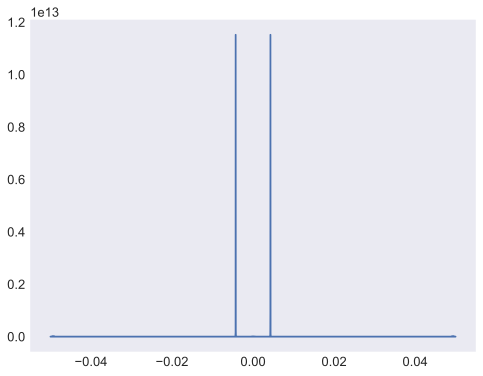

In [26]:
#mz(x)
plt.figure()
plt.title('$\hat m_z(x)$')
plt.plot(space,np.arctan(tan))
plt.xlabel('t (ns)')
plt.ylabel('mz average')
plt.legend(['mz'])
plt.show()
amp=np.abs(np.fft.fft(dmz))**2
f_axis=np.fft.fftfreq(numCells,d=cx)
plt.plot(f_axis/1e9, amp)